In [1]:
import pandas as pd
import numpy as np
import ojsim
sim = ojsim.OJSimulator()
X, Y = sim.formulized_train

In [2]:
log_pr_train, volu_train = sim.train

In [3]:
y = Y - X[:,0,-1,:]

In [4]:
def ziwei(A,B):
    return -(A.values[-1] - A.values[-30])

In [5]:
sim.submit(ziwei)

Total time used: 2.064s
Pairwise correlation:
	asset 0 = 0.00010
	asset 1 = 0.05465
	asset 2 = -0.03260
	asset 3 = -0.00302
	asset 4 = 0.06839
	asset 5 = 0.00672
	asset 6 = 0.03942
	asset 7 = -0.00303
	asset 8 = 0.08684
	asset 9 = 0.06657
	mean correlation = 0.02840
Overall correlation: 0.01536
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(2.064357042312622,
 0    0.000097
 1    0.054647
 2   -0.032601
 3   -0.003021
 4    0.068387
 5    0.006716
 6    0.039419
 7   -0.003030
 8    0.086843
 9    0.066566
 dtype: float64,
 0.015356011271315494)

In [7]:
y_error = y - (-(X[:,0,-1,:] - X[:,0,-30,:]))

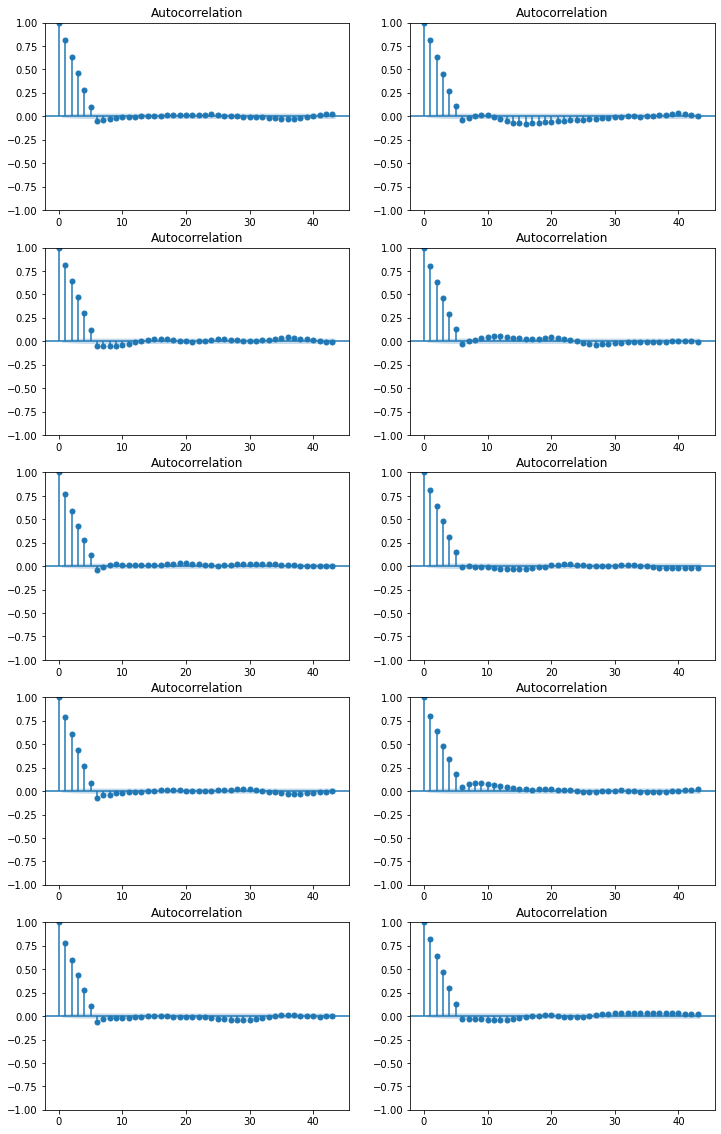

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
_, ax = plt.subplots(5, 2, figsize=(12, 20))
import scipy.stats as stats
import math
import scipy.stats as stats


# mu = 0
# variance = 1
# sigma = math.sqrt(variance)
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for i in range(10):
#     ax[i // 2, i % 2].hist(((y_error - y_error.mean(axis=1)[:,np.newaxis])/(y_error.std(axis=1)/math.sqrt(len(y_error)))[:,np.newaxis])[:,i], bins=100)
#     .plot(x, stats.norm.pdf(x, mu, sigma))
    plot_acf(y_error[:,i], ax=ax[i // 2, i % 2])


plt.show()


In [12]:
y_error.std(axis=1)

array([0.00325465, 0.00330486, 0.00217252, ..., 0.00403115, 0.00267184,
       0.00277476])

In [11]:
# construct the huge dim input dataset
def transform(X):
#     prices = X[:,0,[-30,-1],:]
    price_diff = (X[:,0,1:,:] - X[:,0,:-1,:])[:,-30:,:]
#     volu = np.log(X[:,1,:,:] + 1)[:,[-30, -1],:]
    volu_diff = (np.log(X[:,1,1:,:] + 1) - np.log(X[:,1,:-1,:] + 1))[:,-30:,:]
    ziwei_shift = - X[:,0,[-1, -11, -21, -30, -41],:] - X[:,0,[-30, -40, -50, -60, -70],:]

    X_train = np.concatenate([
#         prices, 
        price_diff, 
#         volu, 
        volu_diff,
        ziwei_shift
    ], axis=1)
    return X_train

X_train = transform(X)
print(X_train.shape)
N, _, _ = X_train.shape

(17709, 65, 10)


In [13]:
y_error_class = (y_error > 0).astype(int)

In [26]:
y_error_class[:,0]

array([0, 0, 1, ..., 1, 1, 0])

In [42]:
from sklearn.ensemble import AdaBoostClassifier
clf = []
for i in range(10):
    clf.append(AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train.reshape(N,-1), y_error_class[:,i]))

In [44]:
for i in range(10):
    print(abs(clf[i].predict(X_train.reshape(N,-1) - y_error_class[:,[i]])).sum())


2141
1961
2122
2137
2213
1940
2138
2129
2406
2428


In [49]:
def classifier(A, B):
    X_test = np.stack([A,B],axis=0)[np.newaxis,:]
    X_test = transform(X_test)
    pred = [clf[i].predict(X_test.reshape(1,-1)) for i in range(10)]
    pred = np.array(pred, dtype=float).squeeze()
    return -(A.values[-1] - A.values[-30]) + (pred - 0.5)*y_error.std(0)

sim.submit(classifier)
    

Total time used: 880.950s
Pairwise correlation:
	asset 0 = -0.00888
	asset 1 = 0.05759
	asset 2 = -0.02157
	asset 3 = 0.02168
	asset 4 = 0.08192
	asset 5 = -0.00346
	asset 6 = 0.02960
	asset 7 = -0.00041
	asset 8 = 0.07330
	asset 9 = 0.07156
	mean correlation = 0.03013
Overall correlation: 0.01334
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


(880.9502847194672,
 0   -0.008880
 1    0.057590
 2   -0.021572
 3    0.021682
 4    0.081918
 5   -0.003459
 6    0.029600
 7   -0.000407
 8    0.073303
 9    0.071560
 dtype: float64,
 0.013335653909626134)

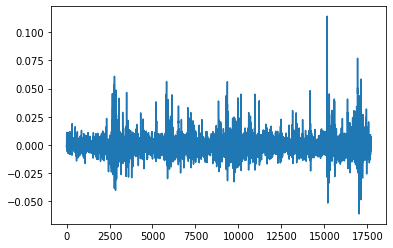

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(y_error)), y_error[:,0])

<AxesSubplot:xlabel='timestamp'>

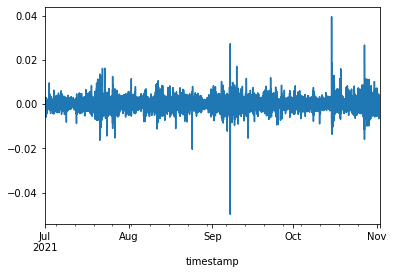

In [22]:
log_pr_train.diff()[0].plot()

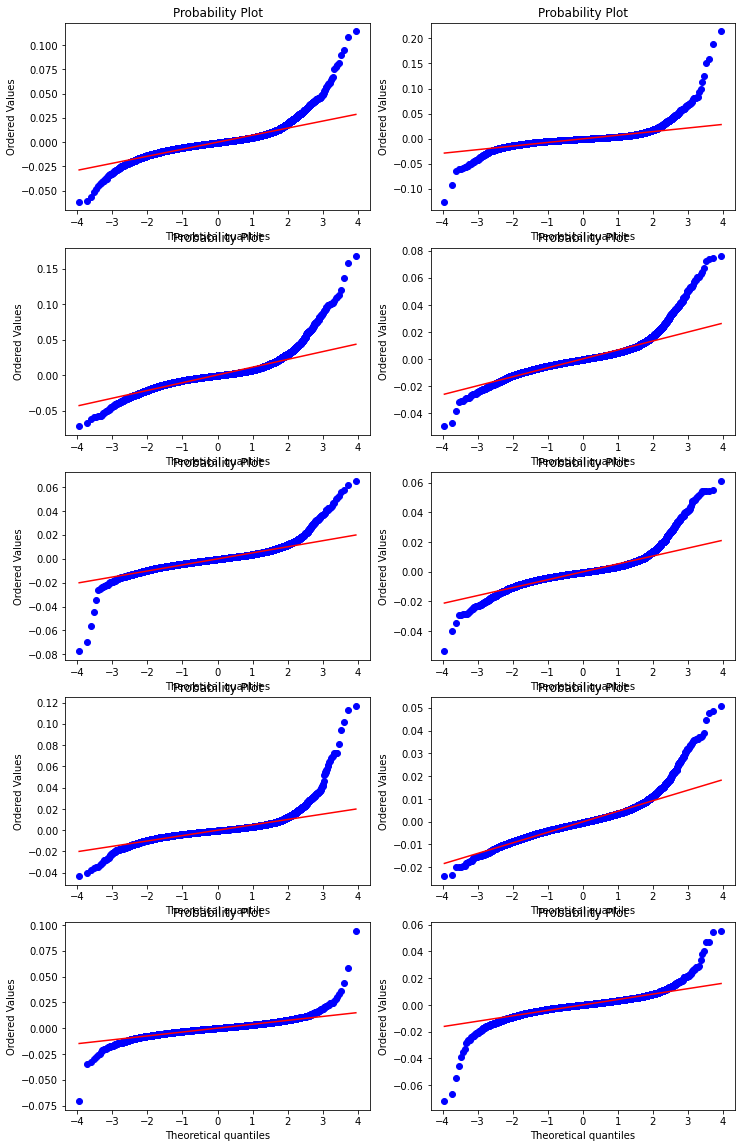

In [76]:
_, ax = plt.subplots(5, 2, figsize=(12, 20))
import scipy.stats as stats
import math
import scipy.stats as stats


# mu = 0
# variance = 1
# sigma = math.sqrt(variance)
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for i in range(10):
#     ax[i // 2, i % 2].hist(((y_error - y_error.mean(axis=1)[:,np.newaxis])/(y_error.std(axis=1)/math.sqrt(len(y_error)))[:,np.newaxis])[:,i], bins=100)
#     ax[i // 2, i % 2].plot(x, stats.norm.pdf(x, mu, sigma))
    stats.probplot(y_error[:,i], dist="norm", plot=ax[i // 2, i % 2])


plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
# SELECT with mutual information
def select_feature_mi(X_train, y):
    X_train_fs_mi = []
    support = []
    for i in range(10):
        fs = SelectKBest(score_func=mutual_info_regression, k='all')
        fs.fit(X_train, y[:,i])
#         X_train_fs_mi.append(fs.transform(X_train[:,:,i]))
        scores = fs.scores_
        support.append(np.where(scores > scores.max()*0.25)[0])
#         support.append(fs.get_support(True))
    return X_train_fs_mi, support

X_train_fs_mi, support_fs_mi = select_feature_mi(X_train.reshape(N,-1), y_error)

In [ ]:
# Feature Selection using mutual information

_, ax = plt.subplots(5, 2, figsize=(20,15))
for i in range(10):
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(X_train[i], y[:,i])
    for j in range(len(fs.scores_)):
        print('Feature %d: %.4f' %(j, fs.scores_[j]))
    scores = fs.scores_
    scores[scores < scores.max()*0.25] = 0
    print("features to select:", np.where(scores > 0)[0], len(np.where(scores > 0)[0]))
    ax[i // 2, i % 2].bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Dense(nn.Module):
    def __init__(self):
        super(Dense, self).__init__(input_size, hidden_size, output_size=1, pool=False)
        self.lin0 = nn.Linear(input_size, input_size)  # pooling layer
        self.lin1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_size, output_size)
        self.pool = False
    
    def forward(self, x):
        if self.pool:
            x = self.lin0(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = x.squeeze(-1) # b x 10
        return x
    
net = Dense()

ModuleNotFoundError: No module named 'torch'

In [9]:
def get_batch(X, Y, batch_size=32):
    X, Y = X.float(), Y.float()
    n = X.size()[0]
    indices = torch.randint(low=0, high=n, size=(batch_size,))
    return X[indices], Y[indices]

In [ ]:
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
training_steps = 1000
for i in range(training_steps):
    minibatch_x, minibatch_y = get_batch(X, Y)
    output = net(minibatch_x)
    stacked = torch.stack([output, minibatch_y]) #2 x b x 10
    stacked = stacked.transpose(1,2).transpose(0,1) # 10 x 2 x b
    corrs = torch.stack([torch.corrcoef(stacked[i])[0,1] for i in range(10)]) # 10 x 1
    loss = -torch.mean(corrs)
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(loss)